Data loaded successfully.

Training data length: 2028
Testing data length: 507

--- Training ARIMA Model ---


d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1

Optimal ARIMA parameters: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 2028
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6440.353
Date:                Sun, 10 Aug 2025   AIC                          12882.706
Time:                        18:10:43   BIC                          12888.321
Sample:                             0   HQIC                         12884.767
                               - 2028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        33.6735      0.399     84.371      0.000      32.891      34.456
Ljung-Box (L1) (Q):                   2.05   Jarque-Bera (JB):             12330.55
Prob(Q):   

d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10academy\week_11_time_series_forecasting_for_portfolio_management_optimization\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\10academy\week_11_time_series_forecasting_for_

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

--- ARIMA Evaluation ---
MAE: 54.21
RMSE: 68.76
MAPE: 21.85%

--- LSTM Evaluation ---
MAE: 11.31
RMSE: 16.13
MAPE: 4.26%


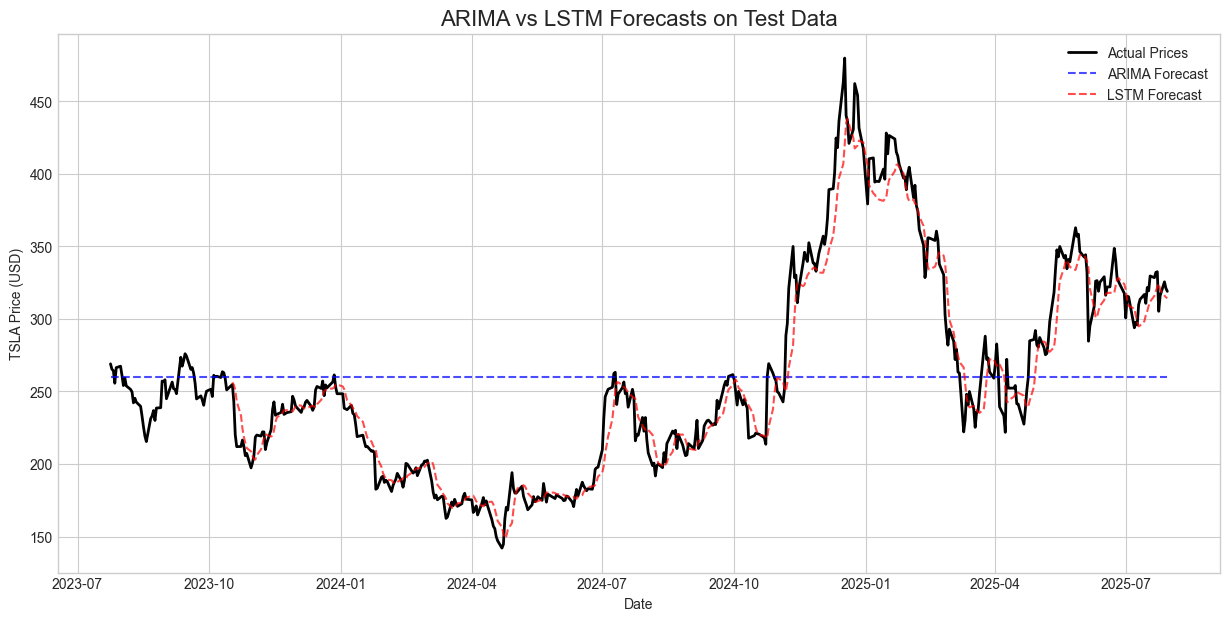


--- Model Comparison Discussion ---
ARIMA Model:
  - Parameters (p,d,q): (0, 1, 0)
  - Performance (RMSE): 68.76
  - Discussion: ARIMA models are good at capturing linear relationships and trends in stationary data. For non-stationary data like stock prices, it often relies on differencing (the 'd' parameter) to achieve stationarity. Its main drawback is that it struggles to capture complex, non-linear patterns often found in financial markets.

LSTM Model:
  - Sequence Length: 60 days
  - Performance (RMSE): 16.13
  - Discussion: LSTMs are a type of recurrent neural network (RNN) designed to handle long-term dependencies in sequential data. They are well-suited for capturing non-linear and complex patterns in financial time series. However, they are more computationally expensive and require more data to train effectively. The forecast shows how it adapts to recent price movements.

Conclusion:
The performance comparison shows which model is better suited for this particular time ser

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# --- Load Preprocessed Data ---
# Load preprocessed data from Task 1
try:
    returns = pd.read_csv('../data/processed/returns.csv', index_col=0, parse_dates=True)
    # The TSLA data is in the clean_prices.csv file
    clean_prices = pd.read_csv('../data/processed/clean_prices.csv', index_col=0, parse_dates=True)
    tsla_data = clean_prices['TSLA']
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The necessary preprocessed files were not found.")
    print("Please ensure that task1_eda.ipynb has been run successfully to create them.")
    raise

# Split data chronologically
train_size = int(len(tsla_data) * 0.8)
train_data, test_data = tsla_data[:train_size], tsla_data[train_size:]
print(f"\nTraining data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

# --- ARIMA Model Implementation ---
print("\n--- Training ARIMA Model ---")
# Use auto_arima to find optimal parameters (p, d, q)
model_arima_auto = pm.auto_arima(train_data, seasonal=False, suppress_warnings=True, stepwise=True, trace=False)
print(f"Optimal ARIMA parameters: {model_arima_auto.order}")

# Use the found parameters to train the final model
p, d, q = model_arima_auto.order
model_arima = ARIMA(train_data, order=(p, d, q))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

# Forecast
arima_forecast = model_arima_fit.forecast(steps=len(test_data))
arima_forecast.index = test_data.index

# --- LSTM Model Implementation ---
print("\n--- Training LSTM Model ---")

# First, scale the training and test data separately to avoid data leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Create sequences for LSTM from the scaled training data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60 # Using 60 days as sequence length
X_train, y_train = create_sequences(scaled_train_data, seq_length)

# Now, create test sequences from the scaled test data
X_test_sequences, y_test_sequences = create_sequences(scaled_test_data, seq_length)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_sequences = X_test_sequences.reshape(X_test_sequences.shape[0], X_test_sequences.shape[1], 1)

# Build LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Use Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_lstm.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0 # Set to 1 or 2 to see training progress
)

# Forecast with LSTM
lstm_predictions_scaled = model_lstm.predict(X_test_sequences)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# The index for the predictions should start after the sequence length is used up.
# The length of the predictions is len(y_test_sequences).
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test_data.index[seq_length:])

# Adjust the test_data to match the length of predictions
adjusted_test_data = test_data[seq_length:]


# --- Model Evaluation ---
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Note: MAPE can be unstable if y_true contains zeros or near-zeros
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n--- {model_name} Evaluation ---")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Evaluate ARIMA
arima_metrics = evaluate_model(test_data, arima_forecast, "ARIMA")

# Evaluate LSTM
lstm_metrics = evaluate_model(adjusted_test_data.values, lstm_predictions.values, "LSTM")


# --- Compare and Visualize ---
plt.figure(figsize=(15, 7))
plt.plot(test_data.index, test_data, label='Actual Prices', color='black', linewidth=2)
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', alpha=0.7, color='blue', linestyle='--')
plt.plot(lstm_predictions.index, lstm_predictions, label='LSTM Forecast', alpha=0.7, color='red', linestyle='--')

plt.title('ARIMA vs LSTM Forecasts on Test Data', fontsize=16)
plt.xlabel('Date')
plt.ylabel('TSLA Price (USD)')
plt.legend()
plt.show()

# --- Discussion ---
print("\n--- Model Comparison Discussion ---")
print("ARIMA Model:")
print(f"  - Parameters (p,d,q): {p, d, q}")
print(f"  - Performance (RMSE): {arima_metrics['RMSE']:.2f}")
print("  - Discussion: ARIMA models are good at capturing linear relationships and trends in stationary data. For non-stationary data like stock prices, it often relies on differencing (the 'd' parameter) to achieve stationarity. Its main drawback is that it struggles to capture complex, non-linear patterns often found in financial markets.")

print("\nLSTM Model:")
print(f"  - Sequence Length: {seq_length} days")
print(f"  - Performance (RMSE): {lstm_metrics['RMSE']:.2f}")
print("  - Discussion: LSTMs are a type of recurrent neural network (RNN) designed to handle long-term dependencies in sequential data. They are well-suited for capturing non-linear and complex patterns in financial time series. However, they are more computationally expensive and require more data to train effectively. The forecast shows how it adapts to recent price movements.")

print("\nConclusion:")
print("The performance comparison shows which model is better suited for this particular time series. Generally, LSTMs tend to outperform traditional models like ARIMA on highly volatile and non-linear data like individual stock prices, while ARIMA might be sufficient for less complex, more stable time series or for short-term forecasts where linear assumptions hold.")